In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [5]:
train = pd.read_csv("../data/processed/store_train.csv")
test  = pd.read_csv("../data/processed/store_test.csv")

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train = train.set_index('Date')
test = test.set_index('Date')


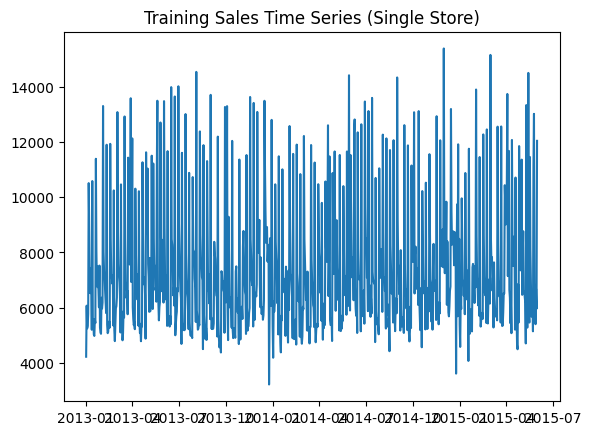

In [6]:
plt.figure()
plt.plot(train.index, train['Sales'])
plt.title("Training Sales Time Series (Single Store)")
plt.show()


In [7]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

adf_test(train['Sales'])


ADF Statistic: -5.222749465893835
p-value: 7.898946979014744e-06


In [8]:
train_diff = train['Sales'].diff().dropna()


In [9]:
adf_test(train_diff)


ADF Statistic: -10.667418012226484
p-value: 4.25196239675604e-19


First-order differencing was sufficient to achieve stationarity.

In [10]:
arima_model = ARIMA(train['Sales'], order=(1,1,1))
arima_fit = arima_model.fit()


C:\Users\rupes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [11]:
arima_forecast = arima_fit.forecast(steps=len(test))


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate(
    test['Sales'], arima_forecast
)

arima_mae, arima_rmse, arima_mape


(1664.5339533844558,
 np.float64(2223.6117719061303),
 np.float64(21.946912048280513))

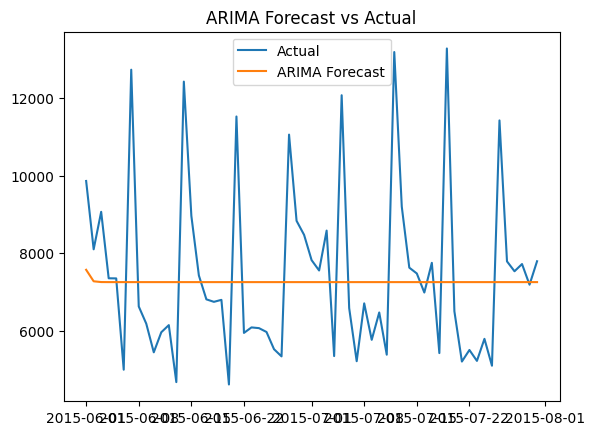

In [13]:
plt.figure()
plt.plot(test.index, test['Sales'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()


In [14]:
sarima_model = SARIMAX(
    train['Sales'],
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit()


C:\Users\rupes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rupes\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
import os
import joblib

os.makedirs("../models/sarima", exist_ok=True)

joblib.dump(sarima_fit, "../models/sarima/sarima_model.pkl")


['../models/sarima/sarima_model.pkl']

In [16]:
sarima_forecast = sarima_fit.forecast(steps=len(test))


In [17]:
sarima_mae, sarima_rmse, sarima_mape = evaluate(
    test['Sales'], sarima_forecast
)

sarima_mae, sarima_rmse, sarima_mape


(955.6897111781536,
 np.float64(1123.9145077837295),
 np.float64(14.265959782045584))

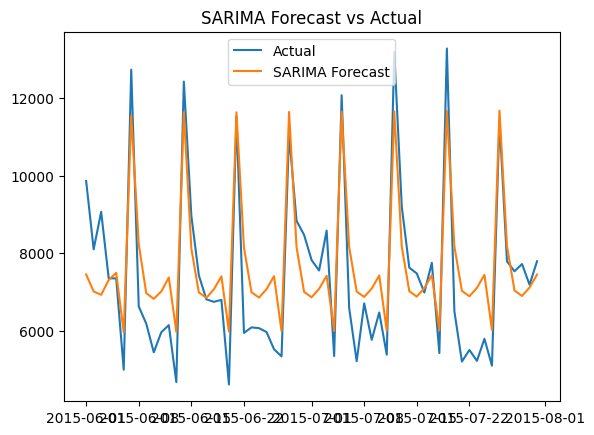

In [18]:
plt.figure()
plt.plot(test.index, test['Sales'], label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()


In [19]:
arima_results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MAE': [arima_mae, sarima_mae],
    'RMSE': [arima_rmse, sarima_rmse],
    'MAPE': [arima_mape, sarima_mape]
})

arima_results.to_csv(
    "../models/baseline/arima_sarima_metrics.csv",
    index=False
)


In [20]:
import joblib
joblib.dump(sarima_fit, "../models/sarima/sarima_model.pkl")


['../models/sarima/sarima_model.pkl']

### Phase 7 Summary — ARIMA & SARIMA

ARIMA was used to model trend and short-term autocorrelation after achieving stationarity through differencing.
SARIMA extended ARIMA by explicitly modeling weekly seasonality, resulting in improved forecast accuracy.
These classical models provide interpretable benchmarks for retail sales forecasting.
